In [108]:
#Project to visualise the cases and deaths due to COVID-19 across London boroughs and to investigate their relationship with demographics.

In [109]:
import pandas as pd
import numpy as np
import geopandas as gdp
import matplotlib.pyplot as plt
import datetime
from selenium import webdriver
from bs4 import BeautifulSoup
import requests
import webbrowser
import os
from sklearn import preprocessing
from sklearn import datasets
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
%matplotlib inline

In [110]:
#!pip3 install geopandas
#!conda install -c conda-forge descartes -y

In [111]:
plt.rcParams['figure.figsize'] = [12, 8]

Number of London boroughs from json file is 33
Index(['id', 'name', 'code', 'area_hectares', 'inner_statistical', 'geometry'], dtype='object')
0       Kingston upon Thames
1                    Croydon
2                    Bromley
3                   Hounslow
4                     Ealing
5                   Havering
6                 Hillingdon
7                     Harrow
8                      Brent
9                     Barnet
10                   Lambeth
11                 Southwark
12                  Lewisham
13                 Greenwich
14                    Bexley
15                   Enfield
16            Waltham Forest
17                 Redbridge
18                    Sutton
19      Richmond upon Thames
20                    Merton
21                Wandsworth
22    Hammersmith and Fulham
23    Kensington and Chelsea
24               Westminster
25                    Camden
26             Tower Hamlets
27                 Islington
28                   Hackney
29              

<Figure size 7200x7200 with 0 Axes>

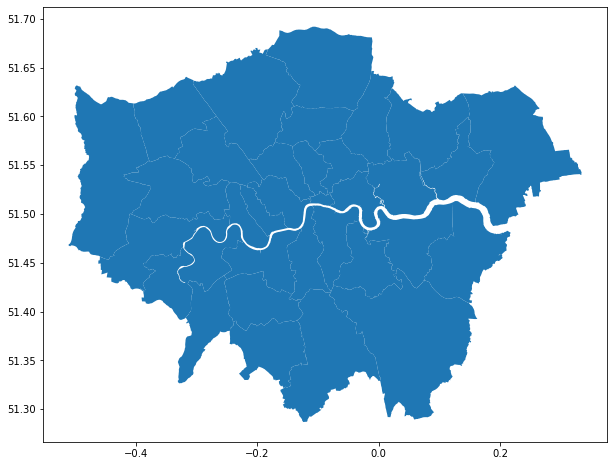

In [112]:
#Importing geojson data
#Source: https://skgrange.github.io/www/data/london_boroughs.json

#Import geojson file and check that it's what we expect
london_map_df = gdp.read_file(r'london_boroughs.json')
print(f'Number of London boroughs from json file is {len(london_map_df)}')
print(london_map_df.columns)
print(london_map_df['name'])
plt.figure(figsize=(100,100))
london_map_df.plot()

In [113]:
#Importing COVID deaths
#File: referencetables1/xlsx

deaths_file = pd.ExcelFile('referencetables1.xlsx')
#Need to start readin in from column 13
covid_deaths_df = deaths_file.parse('Table 5', skiprows = 12)

#Dropping columns with NaN (blank rows in original table)
covid_deaths_df.dropna(axis = 1, how = 'all', inplace = True)

#Renaming some columns for brevity
covid_deaths_df.rename(columns = {"ONS geography MSOA name" : "ONS name", "House of Commons Library MSOA Names" : "HoC Names"}, inplace =True)

covid_deaths_df.head()

,MSOA code,ONS name,HoC Names,March,April,May,June,July,5 month - March to July,March.1,...,May.1,June.1,July.1,5 month - March to July.1,March.2,April.2,May.2,June.2,July.2,5 month - March to July.2
0,E02000001,City of London 001,City of London,1,2,1,0,0,4,6,...,4,5,1,18,7,4,5,5,1,22
1,E02000002,Barking and Dagenham 001,Marks Gate,1,7,0,0,0,8,7,...,5,5,4,29,8,15,5,5,4,37
2,E02000003,Barking and Dagenham 002,Chadwell Heath East,1,7,2,0,0,10,5,...,3,6,5,28,6,16,5,6,5,38
3,E02000004,Barking and Dagenham 003,Eastbrookend,6,6,1,1,0,14,2,...,2,1,5,23,8,19,3,2,5,37
4,E02000005,Barking and Dagenham 004,Becontree Heath,4,2,1,0,0,7,3,...,3,0,3,13,7,6,4,0,3,20


In [114]:
#Dropping regions we are uninterested in
#First removing three numbers so can compare to geojson data
covid_deaths_df['ONS name'] = covid_deaths_df['ONS name'].str.slice(stop=-4)
covid_deaths_df['ONS name']

#Grouping by ONS name
covid_deaths_df = covid_deaths_df.groupby(['ONS name']).sum()
covid_deaths_df.head()

,March,April,May,June,July,5 month - March to July,March.1,April.1,May.1,June.1,July.1,5 month - March to July.1,March.2,April.2,May.2,June.2,July.2,5 month - March to July.2
ONS name,,,,,,,,,,,,,,,,,,
Adur,1,29,10,0,0,40,73,63,60,44,47,287,74,92,70,44,47,327
Allerdale,8,39,15,5,7,74,107,107,83,93,90,480,115,146,98,98,97,554
Amber Valley,8,56,23,14,1,102,132,106,84,94,89,505,140,162,107,108,90,607
Arun,3,34,24,7,0,68,165,231,177,153,151,877,168,265,201,160,151,945
Ashfield,10,85,44,4,4,147,121,100,86,86,79,472,131,185,130,90,83,619


In [115]:
#Removing rows that don't match up with the boroughs in the geojson value
london_map_df.name

covid_deaths_london_df = covid_deaths_df.loc[london_map_df.name]

In [116]:
#Also dropping columns past the first set of deaths (1st is covid-related, 2nd is other, 3rd is all)

print(covid_deaths_london_df.columns[:6])
covid_deaths_london_df = covid_deaths_london_df[covid_deaths_london_df.columns[:6]]
#
#Check that still has 33 boroughs
print(len(covid_deaths_london_df))
covid_deaths_london_df

Index(['March', 'April', 'May', 'June', 'July', '5 month - March to July'], dtype='object')
33


,March,April,May,June,July,5 month - March to July
ONS name,,,,,,
Kingston upon Thames,13,86,30,2,0,131
Croydon,85,327,72,11,2,497
Bromley,54,205,70,11,5,345
Hounslow,54,138,28,10,6,236
Ealing,66,290,41,10,4,411
Havering,40,193,38,3,2,276
Hillingdon,53,225,29,6,2,315
Harrow,89,244,54,10,3,400
Brent,89,344,45,10,3,491


In [117]:
#Merging geojson and deaths datframes together
print(london_map_df.columns)
#Setting map dataframe index to be borough name
london_map_df = london_map_df.set_index('name')
#Concatenation
london_concat_df = pd.concat([london_map_df, covid_deaths_london_df], axis = 1)
london_concat_df

Index(['id', 'name', 'code', 'area_hectares', 'inner_statistical', 'geometry'], dtype='object')


,id,code,area_hectares,inner_statistical,geometry,March,April,May,June,July,5 month - March to July
Kingston upon Thames,1,E09000021,3726.117,False,"MULTIPOLYGON (((-0.33068 51.32901, -0.33059 51...",13,86,30,2,0,131
Croydon,2,E09000008,8649.441,False,"MULTIPOLYGON (((-0.06402 51.31864, -0.06408 51...",85,327,72,11,2,497
Bromley,3,E09000006,15013.487,False,"MULTIPOLYGON (((0.01213 51.29960, 0.01196 51.2...",54,205,70,11,5,345
Hounslow,4,E09000018,5658.541,False,"MULTIPOLYGON (((-0.24456 51.48870, -0.24468 51...",54,138,28,10,6,236
Ealing,5,E09000009,5554.428,False,"MULTIPOLYGON (((-0.41183 51.53408, -0.41188 51...",66,290,41,10,4,411
Havering,6,E09000016,11445.735,False,"MULTIPOLYGON (((0.15869 51.51219, 0.15871 51.5...",40,193,38,3,2,276
Hillingdon,7,E09000017,11570.063,False,"MULTIPOLYGON (((-0.40407 51.61318, -0.40388 51...",53,225,29,6,2,315
Harrow,8,E09000015,5046.330,False,"MULTIPOLYGON (((-0.40407 51.61318, -0.40320 51...",89,244,54,10,3,400
Brent,9,E09000005,4323.270,False,"MULTIPOLYGON (((-0.19657 51.52765, -0.19685 51...",89,344,45,10,3,491
Barnet,10,E09000003,8674.837,False,"MULTIPOLYGON (((-0.19990 51.67017, -0.19970 51...",91,311,48,3,4,457


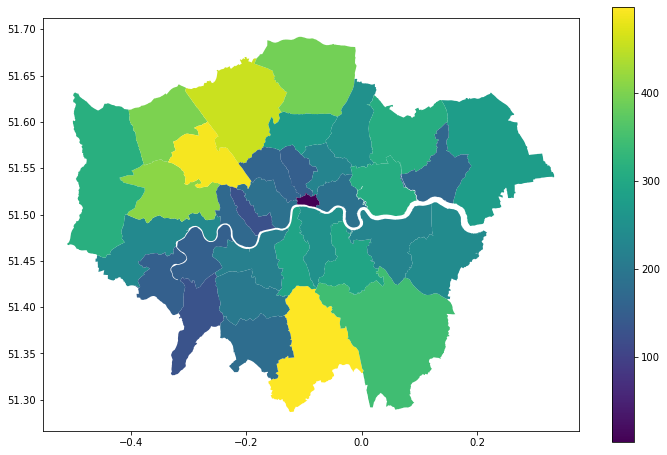

In [118]:
#Removing some columns not needed
london_concat_df.drop(columns = ['id', 'code', 'inner_statistical','March',
       'April', 'May', 'June', 'July',], inplace = True)
#Plotting covid deaths using geopandas
fig, ax = plt.subplots(1,1) #Making subplot of 1x1 to put on legend 
london_concat_df.plot(column = '5 month - March to July', ax = ax, legend = True)

In [119]:
#Importing COVID cases
#File: MSOAs_lastest.xlsx
cases_file = pd.ExcelFile('MSOAs_latest.xlsx')
#Need to start readin in from column 10
covid_cases_df = cases_file.parse('MSOAs-07-10-2020', skiprows = 8)
covid_cases_df.head()

,Region code,Region name,Upper tier local authority code,Upper tier local authority name,Local authority district code,Local authority district name,MSOA code,House of Commons Library MSOA Name,wk_05,wk_06,...,wk_32,wk_33,wk_34,wk_35,wk_36,wk_37,wk_38,wk_39,Column1,latest_7_days
0,E12000007,London,E09000001,City of London,E09000001,City of London,E02000001,City of London,0-2,0-2,...,0-2,0-2,4,0-2,0-2,0-2,0-2,0-2,NaN,5
1,E12000007,London,E09000002,Barking and Dagenham,E09000002,Barking and Dagenham,E02000002,Marks Gate,0-2,0-2,...,0-2,0-2,0-2,0-2,0-2,0-2,5,7,NaN,4
2,E12000007,London,E09000002,Barking and Dagenham,E09000002,Barking and Dagenham,E02000003,Chadwell Heath East,0-2,0-2,...,4,4,0-2,0-2,4,10,9,6,NaN,10
3,E12000007,London,E09000002,Barking and Dagenham,E09000002,Barking and Dagenham,E02000004,Eastbrookend,0-2,0-2,...,0-2,0-2,0-2,0-2,0-2,0-2,4,8,NaN,0-2
4,E12000007,London,E09000002,Barking and Dagenham,E09000002,Barking and Dagenham,E02000005,Becontree Heath,0-2,0-2,...,0-2,0-2,0-2,0-2,5,3,3,8,NaN,7


In [120]:
#Checking if Upper tier local authority name and Local authority district name are ever different
#covid_cases_df[covid_cases_df['Upper tier local authority name'] != covid_cases_df['Local authority district name']]
#Above command came out as blank, so Upper tier and local authority names are the same 

#Dropping some columns we are not interested in
covid_cases_df.drop(columns = ['Region code', 'Region name', 'Upper tier local authority code', 'Local authority district code', 'Upper tier local authority name', 'MSOA code', 'House of Commons Library MSOA Name'], inplace=True)
#Averaging out the 0-2 as 1
covid_cases_df.replace('0-2', 1, inplace=True)

covid_cases_df.head()

,Local authority district name,wk_05,wk_06,wk_07,wk_08,wk_09,wk_10,wk_11,wk_12,wk_13,...,wk_32,wk_33,wk_34,wk_35,wk_36,wk_37,wk_38,wk_39,Column1,latest_7_days
0,City of London,1,1,1,1,1,1,1,4,3,...,1,1,4,1,1,1,1,1,NaN,5
1,Barking and Dagenham,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,5,7,NaN,4
2,Barking and Dagenham,1,1,1,1,1,1,1,1,3,...,4,4,1,1,4,10,9,6,NaN,10
3,Barking and Dagenham,1,1,1,1,1,1,1,1,6,...,1,1,1,1,1,1,4,8,NaN,1
4,Barking and Dagenham,1,1,1,1,1,1,1,1,4,...,1,1,1,1,5,3,3,8,NaN,7


In [121]:
#function that takes a week number in and returns the dates for that week
def week_number_to_week(week_number):
    week_number = float(week_number[3:])
#     print(week_number)
    date_time_obj_start = datetime.datetime(2020,1,1)
    date_time_obj_start = date_time_obj_start + datetime.timedelta(weeks = week_number)
    date_time_obj_end = date_time_obj_start + datetime.timedelta(days = 6)
#     print(date_time_obj_start)
#     print(str(date_time_obj_end))
#     print(date_time_obj_start.day)
#     print(date_time_obj_end.day)
    
    
    #Returns DD/MM
    def slice(dt_object):
        #print(str(dt_object.day) + '/' + str(dt_object.month) ) 
        return (str(dt_object.day) + '/' + str(dt_object.month)) 
    
#     print(slice(date_time_obj_start) + '-' + slice(date_time_obj_end))
    return slice(date_time_obj_start) + '-' + slice(date_time_obj_end)
    
week_number_to_week('wk_05')    

'5/2-11/2'

In [122]:
#Removing some more columns
covid_cases_df.drop(columns = ['Column1', 'latest_7_days'], inplace = True)
#Summing for each authority
covid_cases_df = covid_cases_df.groupby('Local authority district name').sum()
covid_cases_df

,wk_05,wk_06,wk_07,wk_08,wk_09,wk_10,wk_11,wk_12,wk_13,wk_14,...,wk_30,wk_31,wk_32,wk_33,wk_34,wk_35,wk_36,wk_37,wk_38,wk_39
Local authority district name,,,,,,,,,,,,,,,,,,,,,
Adur,8,8,8,8,8,8,8,8,8,15,...,8,8,8,10,10,8,12,14,13,8
Allerdale,12,12,12,12,12,12,12,15,18,36,...,14,14,14,21,12,14,17,17,25,33
Amber Valley,16,16,16,16,16,16,16,19,23,27,...,16,16,16,16,16,16,21,40,47,55
Arun,19,19,19,19,19,19,19,19,21,24,...,19,19,19,19,19,19,33,22,27,25
Ashfield,16,16,16,16,16,16,16,16,20,28,...,16,16,16,21,16,16,40,42,38,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wychavon,19,19,19,19,19,19,19,21,39,45,...,24,19,21,19,23,19,33,28,19,37
Wycombe,23,23,23,23,23,23,25,28,34,32,...,23,27,23,27,23,45,36,30,47,36
Wyre,14,14,14,14,14,14,14,14,22,43,...,14,14,14,16,14,14,25,61,52,77


In [123]:
#Using dictionary in comprehension for renaming week numbers
[covid_cases_df.rename(columns = {col : week_number_to_week(col)}, inplace = True) for col in covid_cases_df.columns]
covid_cases_df.head()

,5/2-11/2,12/2-18/2,19/2-25/2,26/2-3/3,4/3-10/3,11/3-17/3,18/3-24/3,25/3-31/3,1/4-7/4,8/4-14/4,...,29/7-4/8,5/8-11/8,12/8-18/8,19/8-25/8,26/8-1/9,2/9-8/9,9/9-15/9,16/9-22/9,23/9-29/9,30/9-6/10
Local authority district name,,,,,,,,,,,,,,,,,,,,,
Adur,8,8,8,8,8,8,8,8,8,15,...,8,8,8,10,10,8,12,14,13,8
Allerdale,12,12,12,12,12,12,12,15,18,36,...,14,14,14,21,12,14,17,17,25,33
Amber Valley,16,16,16,16,16,16,16,19,23,27,...,16,16,16,16,16,16,21,40,47,55
Arun,19,19,19,19,19,19,19,19,21,24,...,19,19,19,19,19,19,33,22,27,25
Ashfield,16,16,16,16,16,16,16,16,20,28,...,16,16,16,21,16,16,40,42,38,52


In [124]:
len(covid_cases_df.columns)

35

In [125]:
# for row in covid_cases_df.iterrows():
# #     print(type(row))
#     print(list(row))
#     plt.plot(list(row))
#covid_cases_df.plot()
#plt.plot(covid_cases_df)
#for col in covid_cases_df.columns]
covid_cases_df

,5/2-11/2,12/2-18/2,19/2-25/2,26/2-3/3,4/3-10/3,11/3-17/3,18/3-24/3,25/3-31/3,1/4-7/4,8/4-14/4,...,29/7-4/8,5/8-11/8,12/8-18/8,19/8-25/8,26/8-1/9,2/9-8/9,9/9-15/9,16/9-22/9,23/9-29/9,30/9-6/10
Local authority district name,,,,,,,,,,,,,,,,,,,,,
Adur,8,8,8,8,8,8,8,8,8,15,...,8,8,8,10,10,8,12,14,13,8
Allerdale,12,12,12,12,12,12,12,15,18,36,...,14,14,14,21,12,14,17,17,25,33
Amber Valley,16,16,16,16,16,16,16,19,23,27,...,16,16,16,16,16,16,21,40,47,55
Arun,19,19,19,19,19,19,19,19,21,24,...,19,19,19,19,19,19,33,22,27,25
Ashfield,16,16,16,16,16,16,16,16,20,28,...,16,16,16,21,16,16,40,42,38,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wychavon,19,19,19,19,19,19,19,21,39,45,...,24,19,21,19,23,19,33,28,19,37
Wycombe,23,23,23,23,23,23,25,28,34,32,...,23,27,23,27,23,45,36,30,47,36
Wyre,14,14,14,14,14,14,14,14,22,43,...,14,14,14,16,14,14,25,61,52,77


In [126]:
len(london_concat_df.columns)

3

In [127]:
#Adding cases to dataframe
london_concat_df = pd.concat([london_concat_df, covid_cases_df], axis = 1)
#Removing non-London authorities
london_concat_df = london_concat_df.dropna()
london_concat_df

,area_hectares,geometry,5 month - March to July,5/2-11/2,12/2-18/2,19/2-25/2,26/2-3/3,4/3-10/3,11/3-17/3,18/3-24/3,...,29/7-4/8,5/8-11/8,12/8-18/8,19/8-25/8,26/8-1/9,2/9-8/9,9/9-15/9,16/9-22/9,23/9-29/9,30/9-6/10
Kingston upon Thames,3726.117,"MULTIPOLYGON (((-0.33068 51.32901, -0.33059 51...",131.0,20,20,20,20,20,20,20,...,20,20,27,28,25,30,32,34,30,46
Croydon,8649.441,"MULTIPOLYGON (((-0.06402 51.31864, -0.06408 51...",497.0,44,44,44,44,44,44,53,...,44,44,44,48,49,52,75,63,69,92
Bromley,15013.487,"MULTIPOLYGON (((0.01213 51.29960, 0.01196 51.2...",345.0,39,39,39,39,39,39,47,...,39,39,39,48,46,48,66,49,57,65
Hounslow,5658.541,"MULTIPOLYGON (((-0.24456 51.48870, -0.24468 51...",236.0,28,28,28,28,28,28,35,...,36,43,41,51,39,45,82,100,75,137
Ealing,5554.428,"MULTIPOLYGON (((-0.41183 51.53408, -0.41188 51...",411.0,39,39,39,39,39,39,43,...,46,43,52,58,77,58,71,104,96,150
Havering,11445.735,"MULTIPOLYGON (((0.15869 51.51219, 0.15871 51.5...",276.0,30,30,30,30,30,30,30,...,37,38,32,35,42,47,86,74,80,123
Hillingdon,11570.063,"MULTIPOLYGON (((-0.40407 51.61318, -0.40388 51...",315.0,32,32,32,32,32,32,32,...,32,32,42,47,52,48,74,57,107,141
Harrow,5046.330,"MULTIPOLYGON (((-0.40407 51.61318, -0.40320 51...",400.0,30,30,30,30,30,30,42,...,32,40,33,39,40,53,64,68,68,79
Brent,4323.270,"MULTIPOLYGON (((-0.19657 51.52765, -0.19685 51...",491.0,34,34,34,34,34,34,48,...,43,34,37,40,42,50,60,76,87,135
Barnet,8674.837,"MULTIPOLYGON (((-0.19990 51.67017, -0.19970 51...",457.0,41,41,41,41,41,41,53,...,45,63,47,59,67,68,108,99,92,134


In [128]:
#Summing to get cumulative cases until the end of July i.e. 7th month
london_concat_df['Cumulative July cases'] = london_concat_df.loc[:, '5/2-11/2':'22/7-28/7'].sum(axis=1)
london_concat_df.head()

,area_hectares,geometry,5 month - March to July,5/2-11/2,12/2-18/2,19/2-25/2,26/2-3/3,4/3-10/3,11/3-17/3,18/3-24/3,...,5/8-11/8,12/8-18/8,19/8-25/8,26/8-1/9,2/9-8/9,9/9-15/9,16/9-22/9,23/9-29/9,30/9-6/10,Cumulative July cases
Kingston upon Thames,3726.117,"MULTIPOLYGON (((-0.33068 51.32901, -0.33059 51...",131.0,20,20,20,20,20,20,20,...,20,27,28,25,30,32,34,30,46,981
Croydon,8649.441,"MULTIPOLYGON (((-0.06402 51.31864, -0.06408 51...",497.0,44,44,44,44,44,44,53,...,44,44,48,49,52,75,63,69,92,2410
Bromley,15013.487,"MULTIPOLYGON (((0.01213 51.29960, 0.01196 51.2...",345.0,39,39,39,39,39,39,47,...,39,39,48,46,48,66,49,57,65,2007
Hounslow,5658.541,"MULTIPOLYGON (((-0.24456 51.48870, -0.24468 51...",236.0,28,28,28,28,28,28,35,...,43,41,51,39,45,82,100,75,137,1375
Ealing,5554.428,"MULTIPOLYGON (((-0.41183 51.53408, -0.41188 51...",411.0,39,39,39,39,39,39,43,...,43,52,58,77,58,71,104,96,150,1998


In [129]:
london_concat_df['July death:cases'] = london_concat_df['5 month - March to July'] / london_concat_df['Cumulative July cases']
london_concat_df.head()

,area_hectares,geometry,5 month - March to July,5/2-11/2,12/2-18/2,19/2-25/2,26/2-3/3,4/3-10/3,11/3-17/3,18/3-24/3,...,12/8-18/8,19/8-25/8,26/8-1/9,2/9-8/9,9/9-15/9,16/9-22/9,23/9-29/9,30/9-6/10,Cumulative July cases,July death:cases
Kingston upon Thames,3726.117,"MULTIPOLYGON (((-0.33068 51.32901, -0.33059 51...",131.0,20,20,20,20,20,20,20,...,27,28,25,30,32,34,30,46,981,0.133537
Croydon,8649.441,"MULTIPOLYGON (((-0.06402 51.31864, -0.06408 51...",497.0,44,44,44,44,44,44,53,...,44,48,49,52,75,63,69,92,2410,0.206224
Bromley,15013.487,"MULTIPOLYGON (((0.01213 51.29960, 0.01196 51.2...",345.0,39,39,39,39,39,39,47,...,39,48,46,48,66,49,57,65,2007,0.171898
Hounslow,5658.541,"MULTIPOLYGON (((-0.24456 51.48870, -0.24468 51...",236.0,28,28,28,28,28,28,35,...,41,51,39,45,82,100,75,137,1375,0.171636
Ealing,5554.428,"MULTIPOLYGON (((-0.41183 51.53408, -0.41188 51...",411.0,39,39,39,39,39,39,43,...,52,58,77,58,71,104,96,150,1998,0.205706


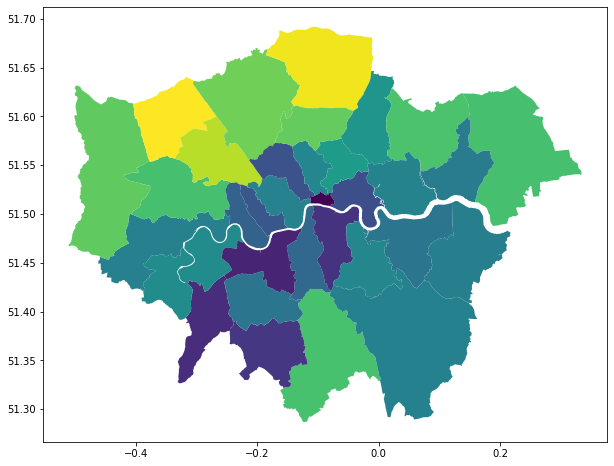

In [130]:
london_concat_df.plot(column = 'July death:cases')

In [131]:
#Importing Race by Borough
page = requests.get('https://en.wikipedia.org/wiki/Demography_of_London')
soup_object = BeautifulSoup(page.content, 'html.parser')
soup_object.prettify()

'<!DOCTYPE html>\n<html class="client-nojs" dir="ltr" lang="en">\n <head>\n  <meta charset="utf-8"/>\n  <title>\n   Demography of London - Wikipedia\n  </title>\n  <script>\n   document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"70cc2aef-0f56-40b2-934b-503838dfc5ea","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"Demography_of_London","wgTitle":"Demography of London","wgCurRevisionId":980250069,"wgRevisionId":980250069,"wgArticleId":4972737,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["CS1 maint: archived copy as title","EngvarB from June 2017","Use dmy dates from June 2017","Geography of London","Demogra

In [132]:
myTable = soup_object.find('table',{'class':'wikitable sortable'})
(myTable.findAll('td'))

[<td>64.1</td>,
 <td>4.8</td>,
 <td>18.5</td>,
 <td>7.7</td>,
 <td>4.8
 </td>,
 <td>58.3</td>,
 <td>4.2</td>,
 <td>15.9</td>,
 <td>20</td>,
 <td>1.6
 </td>,
 <td>81.9</td>,
 <td>2.3</td>,
 <td>6.6</td>,
 <td>8.5</td>,
 <td>0.8
 </td>,
 <td>36.3</td>,
 <td>5.1</td>,
 <td>34.1</td>,
 <td>18.8</td>,
 <td>5.8
 </td>,
 <td>84.3</td>,
 <td>3.5</td>,
 <td>5.2</td>,
 <td>6</td>,
 <td>0.9
 </td>,
 <td>66.3</td>,
 <td>5.6</td>,
 <td>16.1</td>,
 <td>8.2</td>,
 <td>3.8
 </td>,
 <td>78.6</td>,
 <td>3.9</td>,
 <td>12.7</td>,
 <td>2.6</td>,
 <td>2.1
 </td>,
 <td>55.1</td>,
 <td>6.6</td>,
 <td>16.4</td>,
 <td>20.2</td>,
 <td>1.8
 </td>,
 <td>49</td>,
 <td>4.5</td>,
 <td>29.7</td>,
 <td>10.9</td>,
 <td>6
 </td>,
 <td>61</td>,
 <td>5.5</td>,
 <td>11.2</td>,
 <td>17.2</td>,
 <td>5.1
 </td>,
 <td>62.5</td>,
 <td>4.8</td>,
 <td>11.7</td>,
 <td>19.1</td>,
 <td>1.9
 </td>,
 <td>54.7</td>,
 <td>6.4</td>,
 <td>10.5</td>,
 <td>23.1</td>,
 <td>5.3
 </td>,
 <td>60.5</td>,
 <td>6.5</td>,
 <td>9.5</td>,
 <td>18.8</

In [133]:
#Function to extract a float from a td tag
def td_to_float(td_value):
    td_value = td_value[4:-5]
#     print(td_value)
    return float(td_value)
td_to_float('<td>11.8</td>')    

11.8

In [134]:
#Function to extract a string from a th tag
def th_to_string(th_value):
    th_value = th_value[16:-6]
    return th_value
th_to_string('<th scope="row">Wandsworth </th>')

'Wandsworth'

In [135]:
#Extracting borough names    
boroughs = [th_to_string(str(value)) for i, value in enumerate(myTable.findAll('th'))][6:]    
boroughs    

['Barnet',
 'Barking and Dagenham',
 'Bexley',
 'Brent',
 'Bromley',
 'Camden',
 'City of London',
 'Croydon',
 'Ealing',
 'Enfield',
 'Greenwich',
 'Hackney',
 'Haringey',
 'Harrow',
 'Havering',
 'Hammersmith and Fulham',
 'Hillingdon',
 'Hounslow',
 'Islington',
 'Kensington and Chelsea',
 'Kingston upon Thames',
 'Lambeth',
 'Lewisham',
 'Merton',
 'Newham',
 'Redbridge',
 'Richmond upon Thames',
 'Southwark',
 'Sutton',
 'Tower Hamlets',
 'Waltham Forest',
 'Wandsworth',
 'Westminster']

In [136]:
#Extracting races
races = [th_to_string(str(value)) for i, value in enumerate(myTable.findAll('th'))][1:6]
races

['White', 'Mixed', 'Asian', 'Black', 'Other']

In [137]:
#Extracting data
demographic_data = [td_to_float(str(value)) for i, value in enumerate(myTable.findAll('td'))]
#Reshaping
demographic_data = np.array(demographic_data).reshape(33, 5)
demographic_data

array([[64.1,  4.8, 18.5,  7.7,  4.8],
       [58.3,  4.2, 15.9, 20. ,  1.6],
       [81.9,  2.3,  6.6,  8.5,  0.8],
       [36.3,  5.1, 34.1, 18.8,  5.8],
       [84.3,  3.5,  5.2,  6. ,  0.9],
       [66.3,  5.6, 16.1,  8.2,  3.8],
       [78.6,  3.9, 12.7,  2.6,  2.1],
       [55.1,  6.6, 16.4, 20.2,  1.8],
       [49. ,  4.5, 29.7, 10.9,  6. ],
       [61. ,  5.5, 11.2, 17.2,  5.1],
       [62.5,  4.8, 11.7, 19.1,  1.9],
       [54.7,  6.4, 10.5, 23.1,  5.3],
       [60.5,  6.5,  9.5, 18.8,  4.7],
       [42.2,  4. , 42.6,  8.2,  2.9],
       [87.7,  2.1,  4.9,  4.8,  0.6],
       [68.1,  5.5,  9.1, 11.8,  5.5],
       [60.6,  3.8, 25.3,  7.3,  3. ],
       [51.4,  4.1, 34.4,  6.6,  3.6],
       [68.2,  6.5,  9.2, 12.8,  3.4],
       [70.6,  5.7, 10. ,  6.5,  7.2],
       [74.5,  3.9, 16.3,  2.5,  2.7],
       [57.1,  7.6,  6.9, 25.9,  2.4],
       [53.5,  7.4,  9.3, 27.2,  2.6],
       [64.9,  4.7, 18.1, 10.4,  1.9],
       [29. ,  4.5, 43.5, 19.6,  3.5],
       [42.5,  4.1, 41.8,

In [138]:
demographics_df = pd.DataFrame(index=(boroughs), columns = races, data = demographic_data)
demographics_df

,White,Mixed,Asian,Black,Other
Barnet,64.1,4.8,18.5,7.7,4.8
Barking and Dagenham,58.3,4.2,15.9,20.0,1.6
Bexley,81.9,2.3,6.6,8.5,0.8
Brent,36.3,5.1,34.1,18.8,5.8
Bromley,84.3,3.5,5.2,6.0,0.9
Camden,66.3,5.6,16.1,8.2,3.8
City of London,78.6,3.9,12.7,2.6,2.1
Croydon,55.1,6.6,16.4,20.2,1.8
Ealing,49.0,4.5,29.7,10.9,6.0
Enfield,61.0,5.5,11.2,17.2,5.1


In [139]:
#Concatenating demographic information 
london_concat_df = pd.concat([london_concat_df, demographics_df], axis = 1)
#Removing NaN values
london_concat_df = london_concat_df.dropna()
london_concat_df

,area_hectares,geometry,5 month - March to July,5/2-11/2,12/2-18/2,19/2-25/2,26/2-3/3,4/3-10/3,11/3-17/3,18/3-24/3,...,16/9-22/9,23/9-29/9,30/9-6/10,Cumulative July cases,July death:cases,White,Mixed,Asian,Black,Other
Kingston upon Thames,3726.117,"MULTIPOLYGON (((-0.33068 51.32901, -0.33059 51...",131.0,20,20,20,20,20,20,20,...,34,30,46,981,0.133537,74.5,3.9,16.3,2.5,2.7
Croydon,8649.441,"MULTIPOLYGON (((-0.06402 51.31864, -0.06408 51...",497.0,44,44,44,44,44,44,53,...,63,69,92,2410,0.206224,55.1,6.6,16.4,20.2,1.8
Bromley,15013.487,"MULTIPOLYGON (((0.01213 51.29960, 0.01196 51.2...",345.0,39,39,39,39,39,39,47,...,49,57,65,2007,0.171898,84.3,3.5,5.2,6.0,0.9
Hounslow,5658.541,"MULTIPOLYGON (((-0.24456 51.48870, -0.24468 51...",236.0,28,28,28,28,28,28,35,...,100,75,137,1375,0.171636,51.4,4.1,34.4,6.6,3.6
Ealing,5554.428,"MULTIPOLYGON (((-0.41183 51.53408, -0.41188 51...",411.0,39,39,39,39,39,39,43,...,104,96,150,1998,0.205706,49.0,4.5,29.7,10.9,6.0
Havering,11445.735,"MULTIPOLYGON (((0.15869 51.51219, 0.15871 51.5...",276.0,30,30,30,30,30,30,30,...,74,80,123,1342,0.205663,87.7,2.1,4.9,4.8,0.6
Hillingdon,11570.063,"MULTIPOLYGON (((-0.40407 51.61318, -0.40388 51...",315.0,32,32,32,32,32,32,32,...,57,107,141,1486,0.211978,60.6,3.8,25.3,7.3,3.0
Harrow,5046.330,"MULTIPOLYGON (((-0.40407 51.61318, -0.40320 51...",400.0,30,30,30,30,30,30,42,...,68,68,79,1649,0.242571,42.2,4.0,42.6,8.2,2.9
Brent,4323.270,"MULTIPOLYGON (((-0.19657 51.52765, -0.19685 51...",491.0,34,34,34,34,34,34,48,...,76,87,135,2142,0.229225,36.3,5.1,34.1,18.8,5.8
Barnet,8674.837,"MULTIPOLYGON (((-0.19990 51.67017, -0.19970 51...",457.0,41,41,41,41,41,41,53,...,99,92,134,2119,0.215668,64.1,4.8,18.5,7.7,4.8


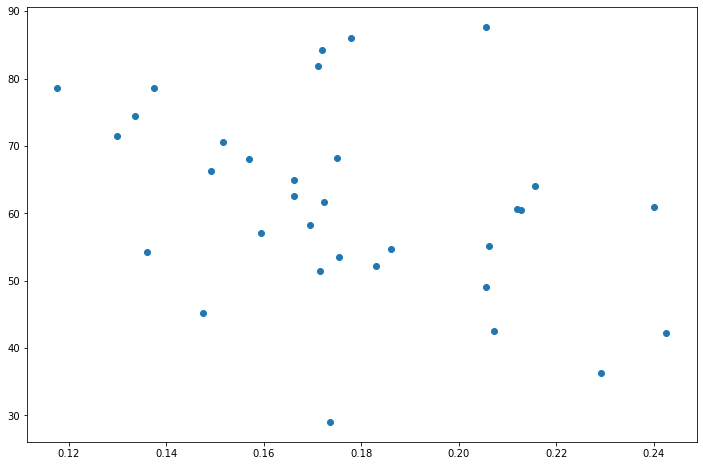

In [140]:
plt.scatter(london_concat_df['July death:cases'], london_concat_df['White'])

Coefficients: [[-0.00084006]]
RMSE: 0.029241235045928186
CoefFicient of determination (r^2): 0.14090269213840378


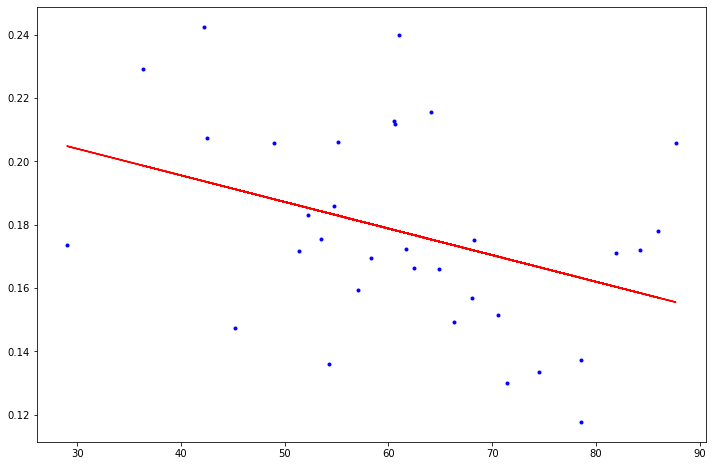

In [141]:
#Modelling data using scikit learn

#Choosing which features to use
X1 = london_concat_df[['White']]
Y1 = london_concat_df[['July death:cases']]

regression_model = linear_model.LinearRegression()
regression_model.fit(X1, Y1)

y1_pred = regression_model.predict(X1)

print(f'Coefficients: {regression_model.coef_}')
print(f'RMSE: {np.sqrt(mean_squared_error(Y1, y1_pred))}')
print(f'CoefFicient of determination (r^2): {r2_score(Y1, y1_pred)}')
      
plt.plot(X1, Y1, '.', color = 'blue')
plt.plot(X1, y1_pred, '-', color = 'red')      


In [142]:
#Importing Excel file with median age and populations
mid_year_estimates_file = pd.ExcelFile('ukmidyearestimates20192020ladcodes.xls')
median_age_df = mid_year_estimates_file.parse('MYE 6', skiprows = 4)
#Dropping irrelevant columns
median_age_df = median_age_df[['Name', 'Mid-2019']]
#Filtering down to London boroughs and concating
london_concat_df = pd.concat([london_concat_df, median_age_df.dropna().set_index('Name').rename(columns = {'Mid-2019' : 'Median Age'})], axis = 1).dropna()
london_concat_df
# median_age_df.head()

,area_hectares,geometry,5 month - March to July,5/2-11/2,12/2-18/2,19/2-25/2,26/2-3/3,4/3-10/3,11/3-17/3,18/3-24/3,...,23/9-29/9,30/9-6/10,Cumulative July cases,July death:cases,White,Mixed,Asian,Black,Other,Median Age
Kingston upon Thames,3726.117,"MULTIPOLYGON (((-0.33068 51.32901, -0.33059 51...",131.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,...,30.0,46.0,981.0,0.133537,74.5,3.9,16.3,2.5,2.7,37.4
Croydon,8649.441,"MULTIPOLYGON (((-0.06402 51.31864, -0.06408 51...",497.0,44.0,44.0,44.0,44.0,44.0,44.0,53.0,...,69.0,92.0,2410.0,0.206224,55.1,6.6,16.4,20.2,1.8,37.7
Bromley,15013.487,"MULTIPOLYGON (((0.01213 51.29960, 0.01196 51.2...",345.0,39.0,39.0,39.0,39.0,39.0,39.0,47.0,...,57.0,65.0,2007.0,0.171898,84.3,3.5,5.2,6.0,0.9,40.9
Hounslow,5658.541,"MULTIPOLYGON (((-0.24456 51.48870, -0.24468 51...",236.0,28.0,28.0,28.0,28.0,28.0,28.0,35.0,...,75.0,137.0,1375.0,0.171636,51.4,4.1,34.4,6.6,3.6,36.4
Ealing,5554.428,"MULTIPOLYGON (((-0.41183 51.53408, -0.41188 51...",411.0,39.0,39.0,39.0,39.0,39.0,39.0,43.0,...,96.0,150.0,1998.0,0.205706,49.0,4.5,29.7,10.9,6.0,37.1
Havering,11445.735,"MULTIPOLYGON (((0.15869 51.51219, 0.15871 51.5...",276.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,...,80.0,123.0,1342.0,0.205663,87.7,2.1,4.9,4.8,0.6,39.2
Hillingdon,11570.063,"MULTIPOLYGON (((-0.40407 51.61318, -0.40388 51...",315.0,32.0,32.0,32.0,32.0,32.0,32.0,32.0,...,107.0,141.0,1486.0,0.211978,60.6,3.8,25.3,7.3,3.0,36.3
Harrow,5046.330,"MULTIPOLYGON (((-0.40407 51.61318, -0.40320 51...",400.0,30.0,30.0,30.0,30.0,30.0,30.0,42.0,...,68.0,79.0,1649.0,0.242571,42.2,4.0,42.6,8.2,2.9,38.3
Brent,4323.270,"MULTIPOLYGON (((-0.19657 51.52765, -0.19685 51...",491.0,34.0,34.0,34.0,34.0,34.0,34.0,48.0,...,87.0,135.0,2142.0,0.229225,36.3,5.1,34.1,18.8,5.8,35.7
Barnet,8674.837,"MULTIPOLYGON (((-0.19990 51.67017, -0.19970 51...",457.0,41.0,41.0,41.0,41.0,41.0,41.0,53.0,...,92.0,134.0,2119.0,0.215668,64.1,4.8,18.5,7.7,4.8,37.4


In [143]:
populations_df = mid_year_estimates_file.parse('MYE2 - Persons', skiprows = 4)
populations_df = populations_df[['Name', 'All ages']].set_index('Name').rename(columns = {'All ages' : 'Population'}).dropna()
len(populations_df)
london_concat_df = pd.concat([london_concat_df, populations_df], axis = 1).dropna()

In [144]:
#Calculating population density
london_concat_df['Population Density'] = london_concat_df['Population'] / london_concat_df['area_hectares']
london_concat_df.head()

,area_hectares,geometry,5 month - March to July,5/2-11/2,12/2-18/2,19/2-25/2,26/2-3/3,4/3-10/3,11/3-17/3,18/3-24/3,...,Cumulative July cases,July death:cases,White,Mixed,Asian,Black,Other,Median Age,Population,Population Density
Kingston upon Thames,3726.117,"MULTIPOLYGON (((-0.33068 51.32901, -0.33059 51...",131.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,...,981.0,0.133537,74.5,3.9,16.3,2.5,2.7,37.4,177507.0,47.638601
Croydon,8649.441,"MULTIPOLYGON (((-0.06402 51.31864, -0.06408 51...",497.0,44.0,44.0,44.0,44.0,44.0,44.0,53.0,...,2410.0,0.206224,55.1,6.6,16.4,20.2,1.8,37.7,386710.0,44.709248
Bromley,15013.487,"MULTIPOLYGON (((0.01213 51.29960, 0.01196 51.2...",345.0,39.0,39.0,39.0,39.0,39.0,39.0,47.0,...,2007.0,0.171898,84.3,3.5,5.2,6.0,0.9,40.9,332336.0,22.135830
Hounslow,5658.541,"MULTIPOLYGON (((-0.24456 51.48870, -0.24468 51...",236.0,28.0,28.0,28.0,28.0,28.0,28.0,35.0,...,1375.0,0.171636,51.4,4.1,34.4,6.6,3.6,36.4,271523.0,47.984631
Ealing,5554.428,"MULTIPOLYGON (((-0.41183 51.53408, -0.41188 51...",411.0,39.0,39.0,39.0,39.0,39.0,39.0,43.0,...,1998.0,0.205706,49.0,4.5,29.7,10.9,6.0,37.1,341806.0,61.537570


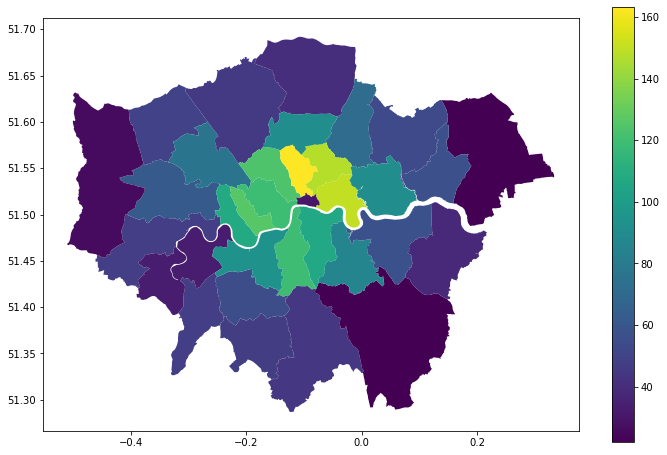

In [145]:
fig, ax = plt.subplots(1,1) #Making subplot of 1x1 to put on legend 
london_concat_df.plot(column = 'Population Density', ax = ax, legend = True)

In [146]:
len(london_concat_df)

33

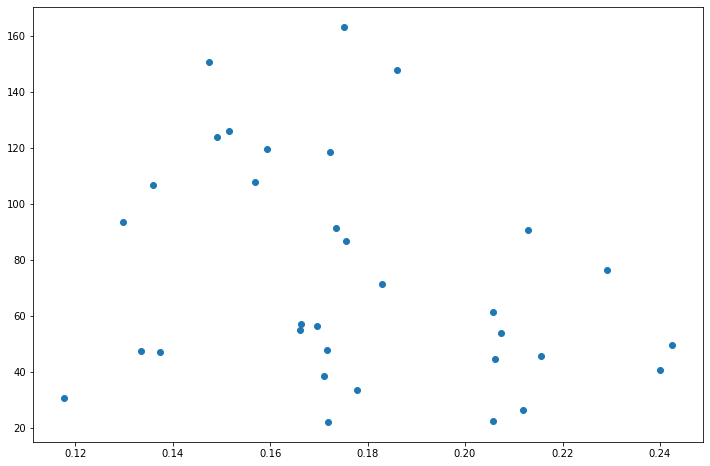

In [147]:
plt.scatter(london_concat_df['July death:cases'], london_concat_df['Population Density'])

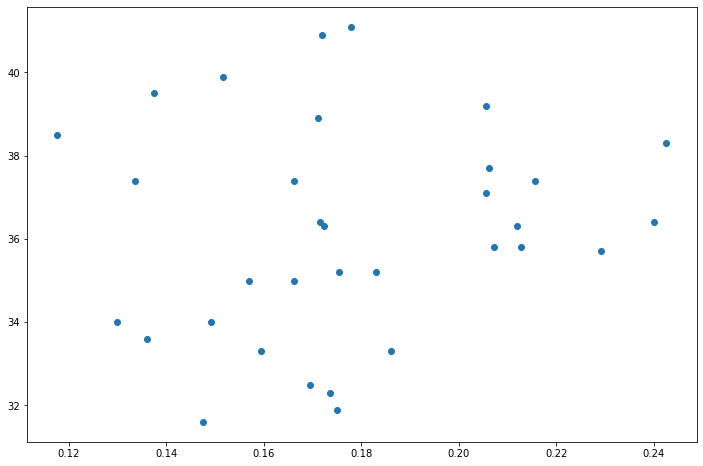

In [148]:
plt.scatter(london_concat_df['July death:cases'], london_concat_df['Median Age'])

In [149]:
def lin_regress_plot(target_variable_column, feature_columns, alpha):
    X1 = london_concat_df[feature_columns]
    Y1 = london_concat_df[[target_variable_column]]

    regression_model = linear_model.Ridge(alpha=alpha)#LinearRegression()
    regression_model.fit(X1, Y1, london_concat_df['Population'])

    y1_pred = regression_model.predict(X1)
    
    print(f'Features : {feature_columns}')
    print(f'Coefficients: {regression_model.coef_}')
    print(f'RMSE: {np.sqrt(mean_squared_error(Y1, y1_pred))}')
    print(f'Coefficient of determination (r^2): {r2_score(Y1, y1_pred)}')
    
    plotting_variable = feature_columns[0]
    
#     plt.plot(X1[plotting_variable], Y1, '.', color = 'blue')
    constant = 2e-3
#     plt.scatter(X1[plotting_variable], Y1, c = 'blue', s = constant * london_concat_df['Population'])
#     plt.scatter(X1[plotting_variable], y1_pred, c = 'red', s = constant * london_concat_df['Population'])
    
    london_concat_df['Pred death:case ratio'] = y1_pred
    
    
    fig, axs = plt.subplots(1,2, figsize=(14, 6)) #Making subplot of 1x1 to put on legend 
    london_concat_df.plot(column = 'Pred death:case ratio', ax = axs[0], cmap = 'Reds')#, legend = True)
    london_concat_df.plot(column = 'July death:cases', ax = axs[1],cmap = 'Reds')#, legend = True)

    sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=0.12, vmax=0.24))
    sm._A = [] # Creates an empty array for the data range
    cbar = fig.colorbar(sm)
#     axs[0].set_aspect('auto')
#     axs[1].set_aspect('auto')
    #plt.show()

    
    #return Y1, y1_pred 
    
    

White
Features : ['White']
Coefficients: [[-0.00063144]]
RMSE: 0.029546432561432922
Coefficient of determination (r^2): 0.12287591214421234
Mixed
Features : ['Mixed']
Coefficients: [[-0.00135575]]
RMSE: 0.03188697201763724
Coefficient of determination (r^2): -0.021592029657071077
Asian
Features : ['Asian']
Coefficients: [[0.00071713]]
RMSE: 0.030127964148866777
Coefficient of determination (r^2): 0.0880090968317857
Black
Features : ['Black']
Coefficients: [[0.00011267]]
RMSE: 0.03170453626460605
Coefficient of determination (r^2): -0.009935748506756825
Other
Features : ['Other']
Coefficients: [[0.00334279]]
RMSE: 0.031239195018554815
Coefficient of determination (r^2): 0.019493215053631663


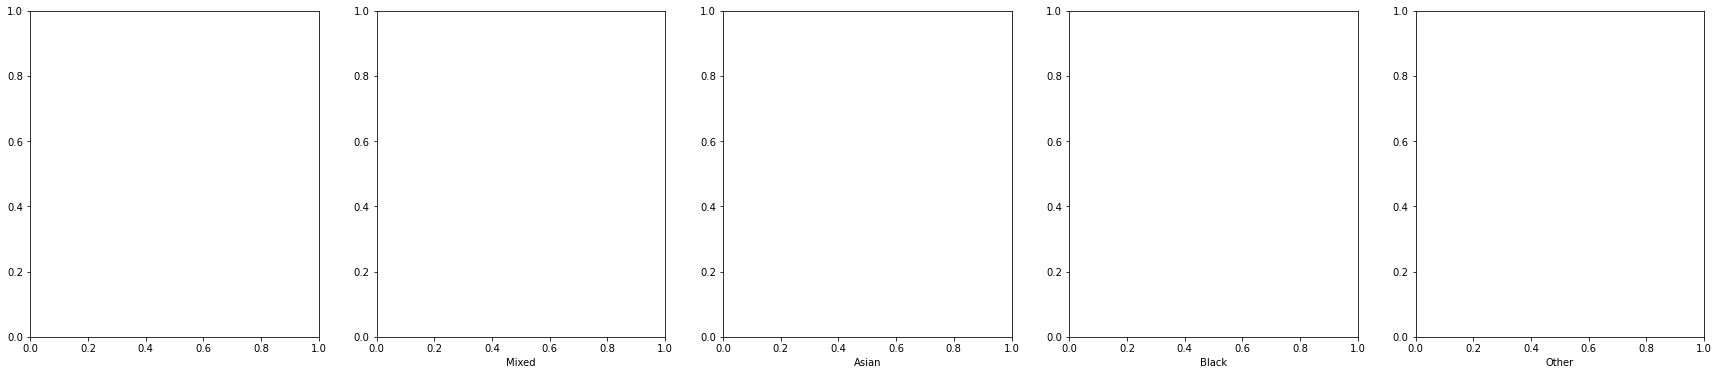

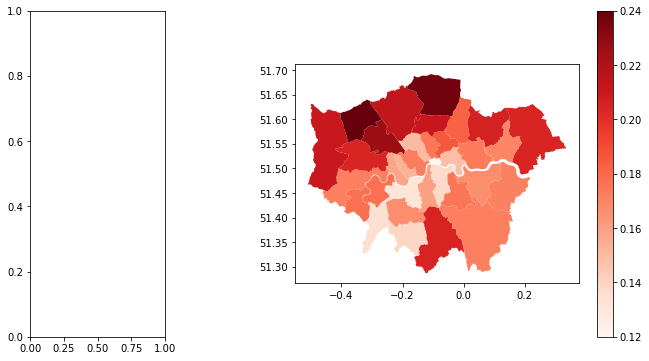

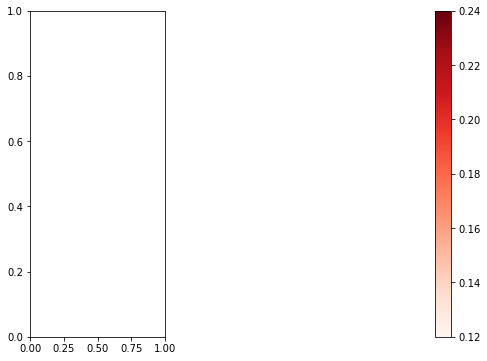

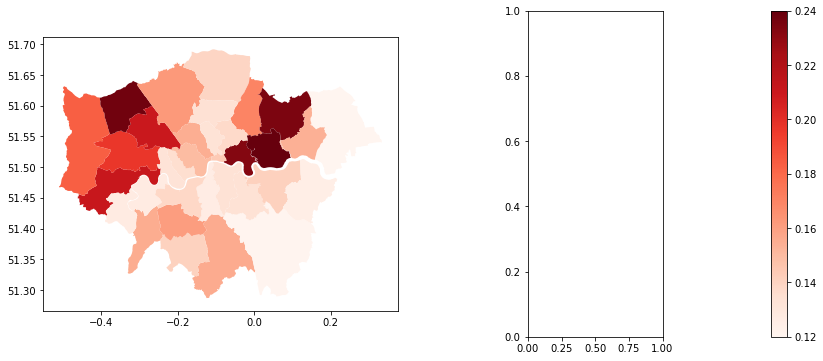

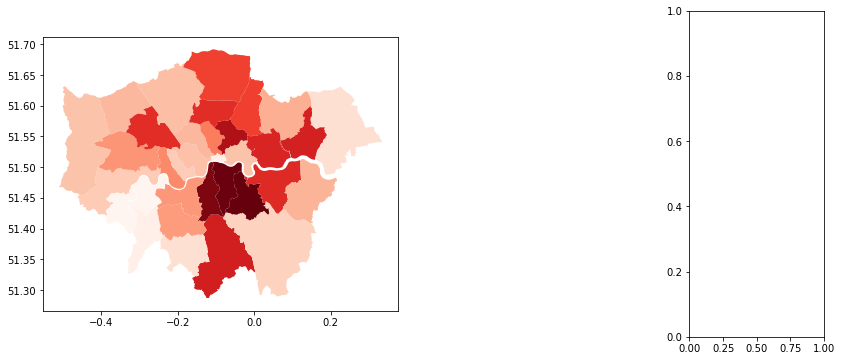

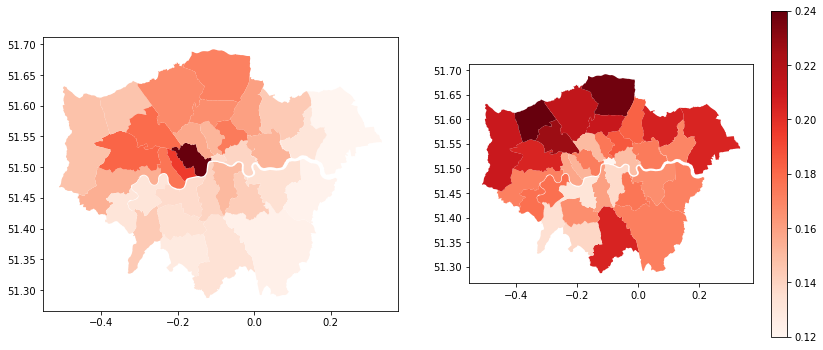

In [154]:
#Setting up subplot
fig, axs = plt.subplots(1, len(races), figsize = (30, 6))
#plt.fig(figsize = (3, 4))
#Plotting deaths:cases ratio against races beside each other 
for i, race in enumerate(races):
    print(race)
    plt.subplot(1, len(races), i + 1)
    lin_regress_plot('July death:cases', [race], alpha = 0.2)
    axs[i].set_xlabel(race)
# axs.axis.set_xticklabels(races)
    

Features : ['Other']
Coefficients: [[0.00334279]]
RMSE: 0.031239195018554815
Coefficient of determination (r^2): 0.019493215053631663


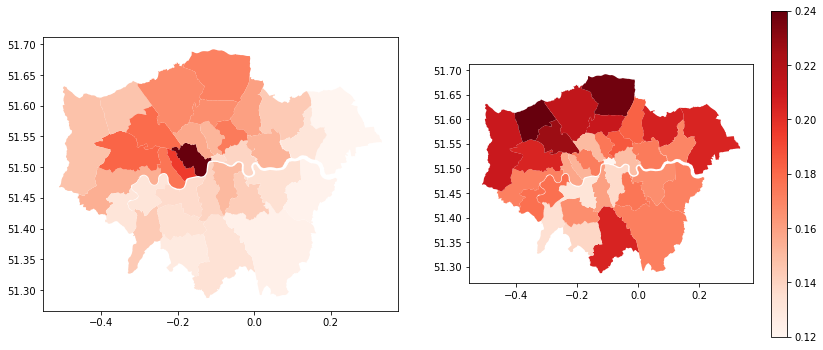

In [153]:
lin_regress_plot('July death:cases', ['Other'], alpha = 0.2)

Features : ['Median Age', 'Population Density', 'White', 'Black', 'Asian', 'Mixed', 'Other']
Coefficients: [[ 0.00235706 -0.00046637 -0.0382193  -0.03707038 -0.03728946 -0.03490134
  -0.03280616]]
RMSE: 0.024991272961825007
Coefficient of determination (r^2): 0.37247982849279226


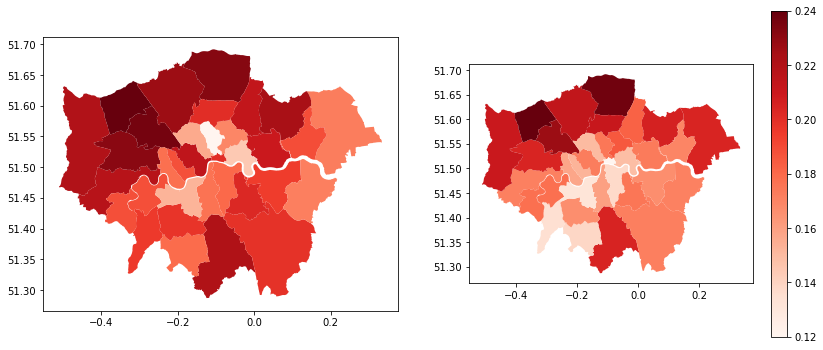

In [152]:
#Modelling two new features using scikitlearn
lin_regress_plot('July death:cases', ['Median Age', 'Population Density', 'White', 'Black', 'Asian', 'Mixed', 'Other'], 0.1)
# lin_regress_plot('July death:cases', ['Median Age'])